# Neural Likelihood Estimation (NLE) vs NPE

**Session 4, Part 2** - Hands-on exercise (~30 min)

In this notebook, we'll:
1. Train **NPE** on the Lotka-Volterra model as a baseline
2. Train **NLE** on the same data
3. Run **MCMC** to obtain posterior samples from NLE
4. **Compare** the two approaches
5. Understand what each estimator learns by **generating synthetic data**
6. Validate with **posterior predictive checks**

## The Key Difference

| Method | What it learns | How to get posterior |
|--------|---------------|---------------------|
| **NPE** | $q_\phi(\theta|x) \approx p(\theta|x)$ | Direct sampling |
| **NLE** | $q_\phi(x|\theta) \approx p(x|\theta)$ | MCMC with $p(\theta|x) \propto q_\phi(x|\theta) \cdot p(\theta)$ |

**NLE learns the likelihood**, then uses Bayes' theorem + MCMC to get the posterior.

In [1]:
import matplotlib.pyplot as plt
import torch
from sbi.inference import NPE, NLE
from sbi.utils import BoxUniform
from sbi.inference import simulate_for_sbi
from functools import partial

from simulators import (
    create_lotka_volterra_prior,
    generate_observed_data,
    lotka_volterra_simulator,
    simulate,
)

In [2]:
import numpy as np
from utils import corner_plot

## 1. Setup: Lotka-Volterra with Summary Statistics

We'll use **20-dimensional** summary statistics (moments + autocorrelation):

**Per population (deer and wolves):**
- 5 moments: mean, std, max, skewness, kurtosis
- 5 autocorrelation lags: capturing temporal structure

This richer representation makes the inference problem more challenging!

In [3]:
# Use small summary statistics (no autocorrelation)
USE_AUTOCORRELATION = True

# Set up prior and observation
prior = create_lotka_volterra_prior()
x_o, theta_true = generate_observed_data(use_autocorrelation=USE_AUTOCORRELATION)

print(f"Prior bounds: {prior.base_dist.low.numpy()} to {prior.base_dist.high.numpy()}")
print(f"True parameters: {theta_true.numpy()}")
print(f"Observation shape: {x_o.shape} (20D summary statistics)")

Prior bounds: [0.05  0.01  0.005 0.005] to [0.15 0.03 0.03 0.15]
True parameters: [0.1  0.02 0.01 0.1 ]
Observation shape: torch.Size([1, 20]) (20D summary statistics)


## 2. Generate Training Data

Both NPE and NLE use the same training data: $(\theta, x)$ pairs from prior $\times$ simulator.

In [4]:
# Generate training data
NUM_SIMULATIONS = 20000
NUM_WORKERS = 10  # Adapt to your computer resourcers

print(f"Generating {NUM_SIMULATIONS} simulations...")

# Define simulator returning summary stats with auto-correlations.
simulator = partial(lotka_volterra_simulator, use_autocorrelation=USE_AUTOCORRELATION)

# Use sbi helper function to simulate in parallel
theta_train, x_train = simulate_for_sbi(simulator, prior, NUM_SIMULATIONS, num_workers=NUM_WORKERS)

print(f"Training data shapes: theta={theta_train.shape}, x={x_train.shape}")

Generating 20000 simulations...


  0%|          | 0/20000 [00:00<?, ?it/s]

Training data shapes: theta=torch.Size([20000, 4]), x=torch.Size([20000, 20])


## 3. Train NPE (Baseline)

First, let's train NPE as our baseline. This should be familiar from Session 3.

In [5]:
# Train NPE
print("Training NPE...")
npe_trainer = NPE(prior)
npe_trainer.append_simulations(theta_train, x_train)
npe_net = npe_trainer.train(training_batch_size=1000)

# Build posterior
npe_posterior = npe_trainer.build_posterior()

Training NPE...
 Neural network successfully converged after 407 epochs.

In [6]:
# Sample from NPE posterior
print("Sampling from NPE posterior...")
npe_samples = npe_posterior.sample((10000,), x=x_o)
print(f"NPE samples shape: {npe_samples.shape}")

Sampling from NPE posterior...


  0%|          | 0/10000 [00:00<?, ?it/s]

NPE samples shape: torch.Size([10000, 4])


## 4. Train NLE

Now let's train NLE. The setup is almost identical to NPE!

In [7]:
# Train NLE
print("Training NLE...")
nle_trainer = NLE(prior)
nle_trainer.append_simulations(theta_train, x_train)
nle_net = nle_trainer.train(training_batch_size=1000);

Training NLE...
 Neural network successfully converged after 672 epochs.

## 5. MCMC Sampling from NLE

Here's the key difference: NLE learns the **likelihood** $p(x|\theta)$, not the posterior.

To get posterior samples, we need to run MCMC:

$$p(\theta|x) \propto p(x|\theta) \cdot p(\theta)$$

The `sbi` package handles this for us with `build_posterior(mcmc_method=...)`.

### Think First!

**Q: Why does NLE require MCMC while NPE doesn't?**

<details>
<summary>Click to reveal answer</summary>

- **NPE** directly learns $p(\theta|x)$ as a normalizing flow, which we can sample from directly
- **NLE** learns $p(x|\theta)$ - to get the posterior, we need to combine it with the prior via Bayes' theorem
- The normalizing constant $p(x)$ is intractable, so we use MCMC to sample from the unnormalized posterior

</details>

In [8]:
# Build NLE posterior with MCMC
# Available methods: "slice_np", "slice_np_vectorized", "hmc", "nuts"

nle_posterior = nle_trainer.build_posterior()

/Users/janteusen/qode/sbi-hackathon-2026/.venv/lib/python3.12/site-packages/sbi/inference/posteriors/mcmc_posterior.py:126: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


### Exercise: Sample from the NLE Posterior

Complete the code below to sample from the NLE posterior.

**Hint:** The API is the same as NPE, but MCMC will take longer!

In [9]:
# TODO: Sample 10,000 samples from the NLE posterior given observation x_o
# This will take ~30-60 seconds due to MCMC

print("Sampling from NLE posterior (MCMC)... this takes a moment.")

nle_samples = nle_posterior.sample((10_000,), x=x_o)  # YOUR CODE HERE

print(f"NLE samples shape: {nle_samples.shape}")

Sampling from NLE posterior (MCMC)... this takes a moment.


Generating 20 MCMC inits via resample strategy:   0%|          | 0/20 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/15000 [00:00<?, ?it/s]

NLE samples shape: torch.Size([10000, 4])


In [10]:
# %load solutions/solutions_nb_04.py

## 6. Compare Posteriors: NPE vs NLE

Let's visualize both posteriors and see how they compare.

### Quantitative Comparison

In [11]:
# Quantitative comparison: posterior means and standard deviations
param_names = [r"$\alpha$", r"$\beta$", r"$\delta$", r"$\gamma$"]

print("Posterior comparison:")
print(f"{'Param':<8} {'True':>10} {'NPE mean':>12} {'NPE std':>10} {'NLE mean':>12} {'NLE std':>10}")
print("-" * 64)
for i, name in enumerate(param_names):
    true_val = theta_true[i].item()
    npe_mean = npe_samples[:, i].mean().item()
    npe_std = npe_samples[:, i].std().item()
    nle_mean = nle_samples[:, i].mean().item()
    nle_std = nle_samples[:, i].std().item()
    print(f"{name:<8} {true_val:>10.4f} {npe_mean:>12.4f} {npe_std:>10.4f} {nle_mean:>12.4f} {nle_std:>10.4f}")

Posterior comparison:
Param          True     NPE mean    NPE std     NLE mean    NLE std
----------------------------------------------------------------
$\alpha$     0.1000       0.1009     0.0040       0.0980     0.0014
$\beta$      0.0200       0.0200     0.0002       0.0199     0.0002
$\delta$     0.0100       0.0100     0.0003       0.0101     0.0001
$\gamma$     0.1000       0.0995     0.0034       0.1010     0.0010


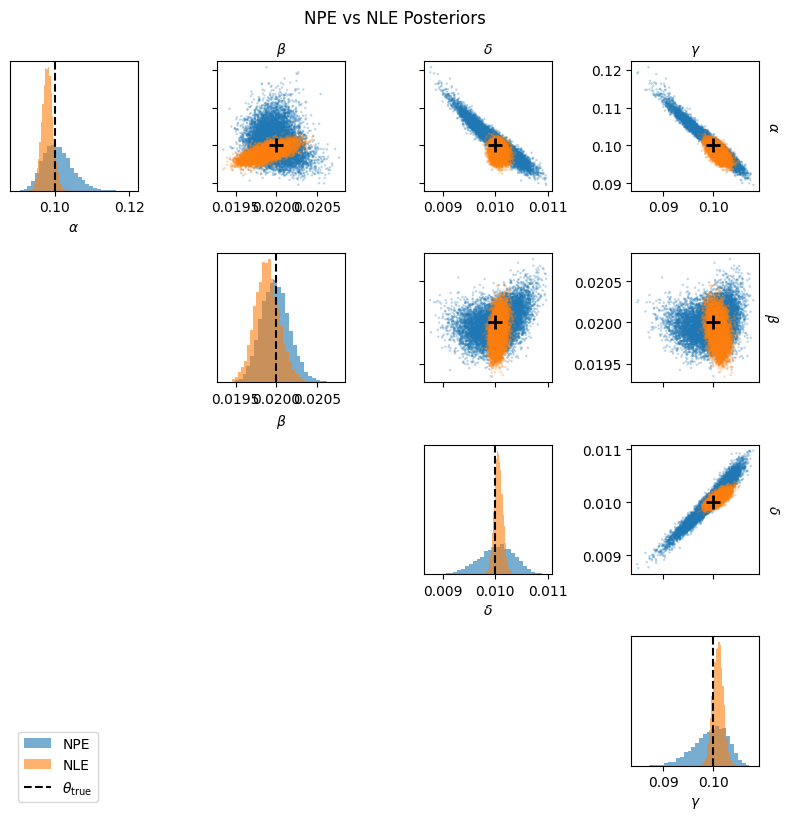

In [12]:
# Visualize posteriors using corner plot
prior_limits = [[prior.base_dist.low[i].item(), prior.base_dist.high[i].item()] 
                for i in range(len(param_names))]

fig, axes = corner_plot(
    [npe_samples, nle_samples],
    labels=["NPE", "NLE"],
    param_names=param_names,
    theta_true=theta_true,
    # limits=prior_limits,  # comment in to show in prior parameter limits.
)
plt.suptitle("NPE vs NLE Posteriors", y=1.02, fontsize=12)
plt.show()

In [13]:
# Save samples for comparison in nb_05 (SNPE notebook)
torch.save({
    'npe_samples': npe_samples,
    'nle_samples': nle_samples,
    'theta_true': theta_true,
    'x_o': x_o,
}, 'npe_nle_samples.pt')
print("Saved NPE and NLE samples to 'npe_nle_samples.pt'")

Saved NPE and NLE samples to 'npe_nle_samples.pt'


## 7. Understanding What the Estimators Learn

Both NPE and NLE train a **conditional density estimator** (a normalizing flow). But what they learn is fundamentally different:

| Method | Estimator learns | Condition on | Sample gives |
|--------|-----------------|--------------|--------------|
| **NPE** | $q_\phi(\theta \| x)$ | observation $x$ | **posterior samples** $\theta$ |
| **NLE** | $q_\phi(x \| \theta)$ | parameters $\theta$ | **synthetic data** $x$ |

### The Key Insight

When you **directly sample** from the trained density estimator:

- **NPE estimator** conditioned on $x_o$ → posterior samples $\theta \sim p(\theta|x_o)$
- **NLE estimator** conditioned on $\theta$ → likelihood samples, i.e., "synthetic simulations" $x \sim p(x|\theta)$

This means with NLE, we can generate synthetic data **without running the simulator**! We just sample from the learned likelihood.

### Sampling from the NPE Estimator

In `sbi`, the trained estimator networks have a distribution-like API, with `.sample` and `log_prob` methods. 

For example, with NPE, we call `sample` on the estimator network to get posterior samples:

```python
# NPE: condition on x, sample theta
theta_samples = npe_net.sample((num_samples,), condition=x_o)
```

This is (almost) what `npe_posterior.sample()` does under the hood!

### Exercise: Generate Synthetic Data from the NLE Estimator

Now it's your turn! With NLE, we can generate synthetic summary statistics by sampling the trained estimator net conditioned on parameter values.

**Your task:** 
1. Take the true parameters `theta_true` (or any theta from the posterior)
2. Use `nle_net.sample()` to generate synthetic summary statistics
3. Compare the synthetic data to the real observation `x_o`

**Hint:** The API is similar to NPE, but you condition on `theta` instead of `x`!

In [38]:
# TODO: Generate synthetic summary statistics from the NLE estimator
# 
# 1. Use nle_net.sample() with the true parameters
# 2. Generate 100 synthetic observations
# 3. The condition should be theta_true (shape: [1, 4] for batch dimension)

num_synthetic = 1000
theta_condition = theta_true.unsqueeze(0)  # Add batch dimension: [4] -> [1, 4]

# YOUR CODE HERE: sample synthetic data from the NLE estimator
x_synthetic_nle = nle_net.sample((num_synthetic,), condition=theta_condition).detach().squeeze(1)

print(f"Synthetic data shape: {x_synthetic_nle.shape}")  # Should be [100, 20]

Synthetic data shape: torch.Size([1000, 20])


In [39]:
# %load solutions/solutions_nb_04_synthetic.py
"""Solution for generating synthetic data from NLE estimator"""

# NLE estimator learns p(x|theta), so we condition on theta and sample x
# This is the reverse of NPE, where we condition on x and sample theta

x_synthetic_nle = nle_net.sample((num_synthetic,), condition=theta_condition).detach().squeeze(1)

print(f"Synthetic data shape: {x_synthetic_nle.shape}")  # Should be [100, 20]

Synthetic data shape: torch.Size([1000, 20])


In [40]:
# Generate ground truth: run the actual simulator with the same theta
# This is what NLE should have learned to emulate!

x_simulated = lotka_volterra_simulator(
    theta_condition.repeat(num_synthetic, 1),  # Repeat theta for num_synthetic runs
    use_autocorrelation=USE_AUTOCORRELATION
)

print(f"Simulated data shape: {x_simulated.shape}")
print(f"NLE synthetic shape:  {x_synthetic_nle.shape}")

Simulated data shape: torch.Size([1000, 20])
NLE synthetic shape:  torch.Size([1000, 20])


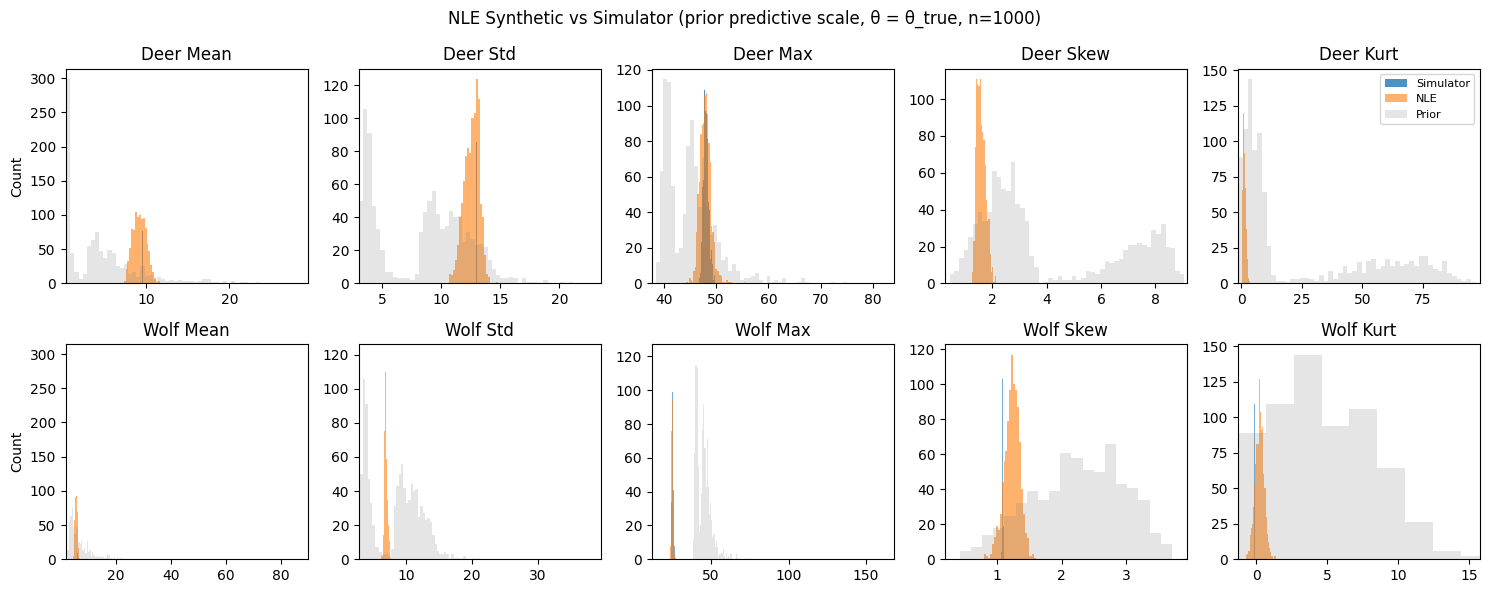

In [53]:
# Compare NLE synthetic data vs actual simulator output
# Use prior predictive ranges to show they're actually quite similar
stat_names = ["Mean", "Std", "Max", "Skew", "Kurt"]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
num_bins = "auto"

for i, name in enumerate(stat_names):
    # Get prior predictive range for this statistic
    x_min_deer = x_train[:, i].min().item()
    x_max_deer = x_train[:, i].max().item()
    x_min_wolf = x_train[:, 10+i].min().item()
    x_max_wolf = x_train[:, 10+i].max().item()
    
    # Deer statistics (indices 0-4)
    ax = axes[0, i]
    ax.hist(x_simulated[:, i], bins=num_bins, alpha=0.8, label='Simulator', color='C0')
    ax.hist(x_synthetic_nle[:, i], bins=num_bins, alpha=0.6, label='NLE', color='C1')
    ax.hist(x_train[:num_synthetic, i], bins=50, alpha=0.2, label='Prior', color='grey')
    ax.set_xlim(x_min_deer, x_max_deer)
    ax.set_title(f'Deer {name}')
    if i == 0:
        ax.set_ylabel('Count')
    if i == 4:
        ax.legend(fontsize=8)

    # Wolf statistics (indices 10-14)
    ax = axes[1, i]
    ax.hist(x_simulated[:, 10+i], bins=num_bins, alpha=0.6, color='C0')
    ax.hist(x_synthetic_nle[:, 10+i], bins=num_bins, alpha=0.6, color='C1')
    ax.hist(x_train[:num_synthetic, i], bins=50, alpha=0.2, label='Prior', color='grey')
    ax.set_xlim(x_min_wolf, x_max_wolf)
    ax.set_title(f'Wolf {name}')
    if i == 0:
        ax.set_ylabel('Count')

plt.suptitle(f'NLE Synthetic vs Simulator (prior predictive scale, θ = θ_true, n={num_synthetic})', fontsize=12)
plt.tight_layout()
plt.show()

### Think First!

**Q: We compared NLE's synthetic data to the simulator at the summary statistics level. Why can't we compare them at the raw time series level?**

<details>
<summary>Click to reveal answer</summary>

NLE was trained on **summary statistics**, not raw time series! It learned $p(x|\theta)$ where $x$ is a 20-dimensional summary vector.

Comparing at the time series level would require:
1. **Training NLE on raw time series** (2000 time points × 2 species = 4000D) — extremely high-dimensional!
2. **Modeling complex temporal dynamics** — the oscillations, correlations, and patterns are hard to capture with standard density estimators
3. **Much more training data** — high-dimensional density estimation needs exponentially more samples

This is why **summary statistics are so important in SBI**: they compress the data to a manageable dimension while (hopefully) preserving the information needed for inference.

</details>

## 8. Posterior Predictive Check

A crucial validation step: do simulations from posterior samples produce data similar to the observation?

We'll generate **synthetic data** from both posteriors and compare.

In [54]:
# Generate synthetic data from posterior samples
n_predictive = 50

# Sample parameters from posteriors
npe_predictive_theta = npe_samples[:n_predictive]
nle_predictive_theta = nle_samples[:n_predictive]

# Simulate summary statistics
npe_predictive_x = lotka_volterra_simulator(npe_predictive_theta, use_autocorrelation=USE_AUTOCORRELATION)
nle_predictive_x = lotka_volterra_simulator(nle_predictive_theta, use_autocorrelation=USE_AUTOCORRELATION)

# Simulate time series for visualization
time = np.arange(0, 200, 0.1)
ts_observed = simulate(theta_true.numpy())
ts_npe = [simulate(npe_predictive_theta[i].numpy()) for i in range(n_predictive)]
ts_nle = [simulate(nle_predictive_theta[i].numpy()) for i in range(n_predictive)]

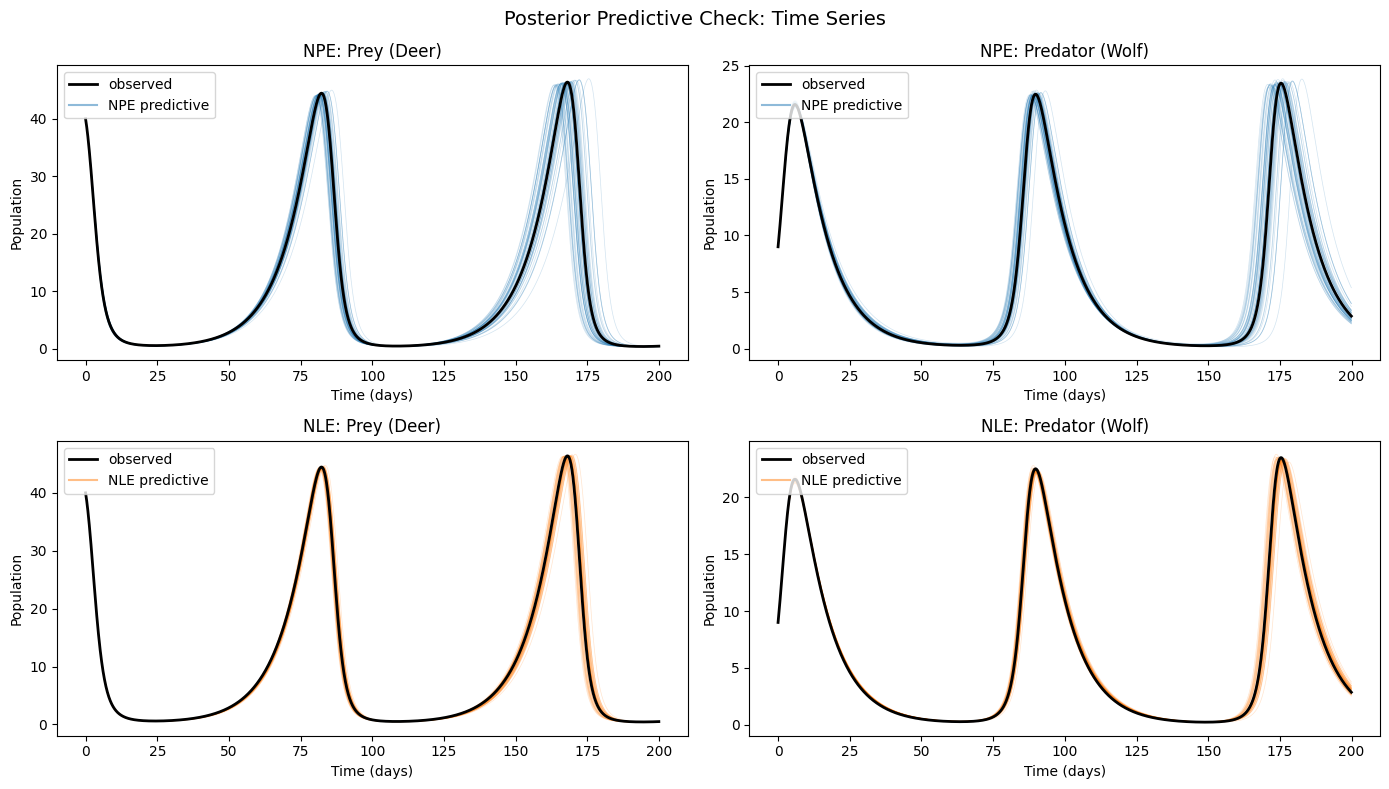

In [55]:
# Posterior predictive: Time series comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# NPE predictive - Prey
ax = axes[0, 0]
for ts in ts_npe:
    ax.plot(time, ts[:, 0], color="C0", alpha=0.2, linewidth=0.5)
ax.plot(time, ts_observed[:, 0], color="k", linewidth=2, label="observed")
ax.plot([], [], color="C0", alpha=0.5, label="NPE predictive")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Population")
ax.set_title("NPE: Prey (Deer)")
ax.legend()

# NPE predictive - Predator
ax = axes[0, 1]
for ts in ts_npe:
    ax.plot(time, ts[:, 1], color="C0", alpha=0.2, linewidth=0.5)
ax.plot(time, ts_observed[:, 1], color="k", linewidth=2, label="observed")
ax.plot([], [], color="C0", alpha=0.5, label="NPE predictive")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Population")
ax.set_title("NPE: Predator (Wolf)")
ax.legend()

# NLE predictive - Prey
ax = axes[1, 0]
for ts in ts_nle:
    ax.plot(time, ts[:, 0], color="C1", alpha=0.2, linewidth=0.5)
ax.plot(time, ts_observed[:, 0], color="k", linewidth=2, label="observed")
ax.plot([], [], color="C1", alpha=0.5, label="NLE predictive")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Population")
ax.set_title("NLE: Prey (Deer)")
ax.legend()

# NLE predictive - Predator
ax = axes[1, 1]
for ts in ts_nle:
    ax.plot(time, ts[:, 1], color="C1", alpha=0.2, linewidth=0.5)
ax.plot(time, ts_observed[:, 1], color="k", linewidth=2, label="observed")
ax.plot([], [], color="C1", alpha=0.5, label="NLE predictive")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Population")
ax.set_title("NLE: Predator (Wolf)")
ax.legend()

plt.suptitle("Posterior Predictive Check: Time Series", fontsize=14)
plt.tight_layout()
plt.show()

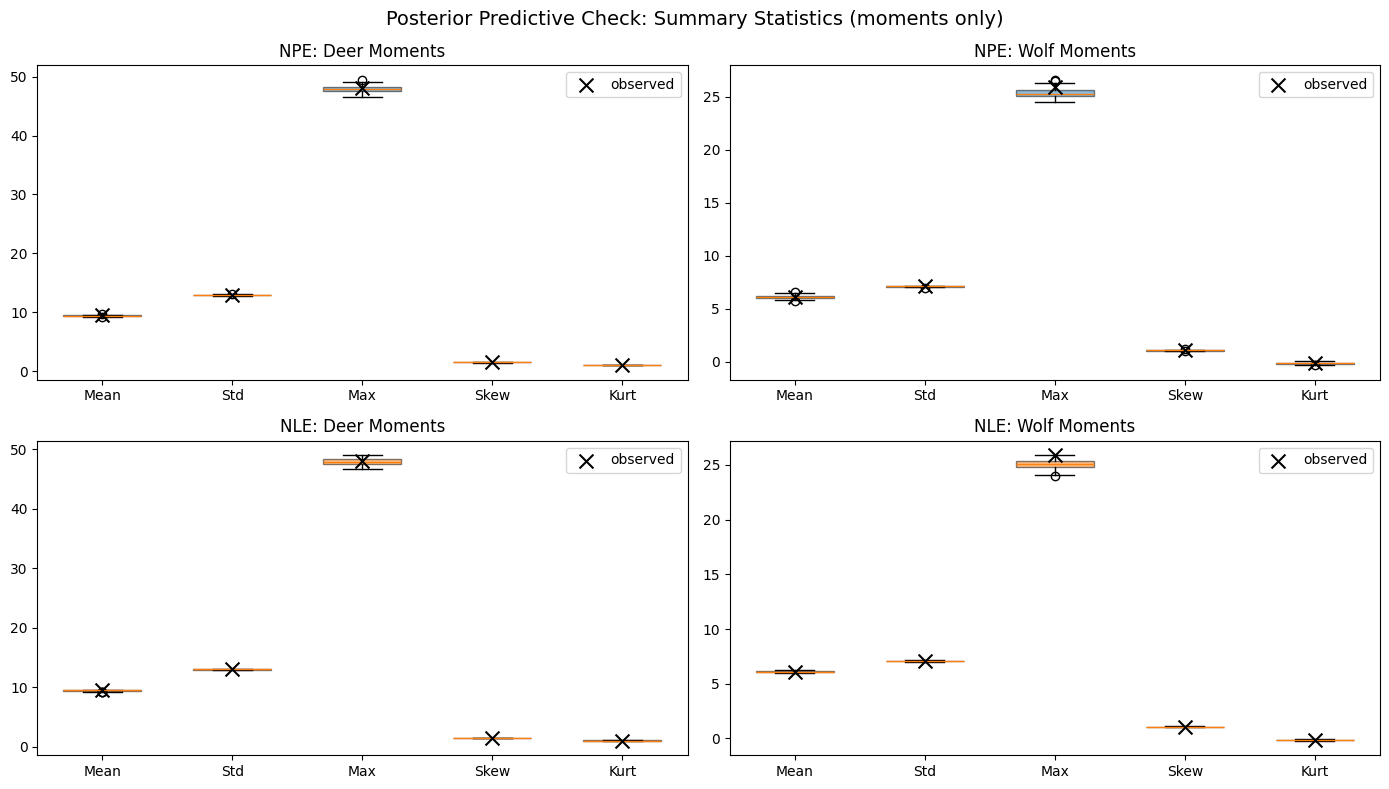

In [56]:
# Posterior predictive: Summary statistics comparison (showing moments only, not autocorrelation)
stat_names = ["Mean", "Std", "Max", "Skew", "Kurt"]
x_obs = x_o.squeeze().numpy()

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

positions = np.arange(5)

# NPE - Deer stats (moments only: indices 0-4)
ax = axes[0, 0]
bp = ax.boxplot(npe_predictive_x[:, :5].numpy(), positions=positions, widths=0.6, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('C0')
    patch.set_alpha(0.5)
ax.scatter(positions, x_obs[:5], color="k", s=100, zorder=10, marker="x", label="observed")
ax.set_xticks(positions)
ax.set_xticklabels(stat_names)
ax.set_title("NPE: Deer Moments")
ax.legend()

# NPE - Wolf stats (moments only: indices 10-14)
ax = axes[0, 1]
bp = ax.boxplot(npe_predictive_x[:, 10:15].numpy(), positions=positions, widths=0.6, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('C0')
    patch.set_alpha(0.5)
ax.scatter(positions, x_obs[10:15], color="k", s=100, zorder=10, marker="x", label="observed")
ax.set_xticks(positions)
ax.set_xticklabels(stat_names)
ax.set_title("NPE: Wolf Moments")
ax.legend()

# NLE - Deer stats (moments only: indices 0-4)
ax = axes[1, 0]
bp = ax.boxplot(nle_predictive_x[:, :5].numpy(), positions=positions, widths=0.6, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('C1')
    patch.set_alpha(0.5)
ax.scatter(positions, x_obs[:5], color="k", s=100, zorder=10, marker="x", label="observed")
ax.set_xticks(positions)
ax.set_xticklabels(stat_names)
ax.set_title("NLE: Deer Moments")
ax.legend()

# NLE - Wolf stats (moments only: indices 10-14)
ax = axes[1, 1]
bp = ax.boxplot(nle_predictive_x[:, 10:15].numpy(), positions=positions, widths=0.6, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('C1')
    patch.set_alpha(0.5)
ax.scatter(positions, x_obs[10:15], color="k", s=100, zorder=10, marker="x", label="observed")
ax.set_xticks(positions)
ax.set_xticklabels(stat_names)
ax.set_title("NLE: Wolf Moments")
ax.legend()

plt.suptitle("Posterior Predictive Check: Summary Statistics (moments only)", fontsize=14)
plt.tight_layout()
plt.show()

## 9. Discussion: Why Does NLE Win Here?

Looking at the results above, **NLE produces tighter, more accurate posteriors** than NPE on this problem. Why?

### The Likelihood Has Simpler Structure

In this Lotka-Volterra example:
- The **posterior is sharply concentrated** in a small region of parameter space
- NPE must learn the mapping $x \to p(\theta|x)$ for the **entire prior space** (amortized)
- With limited simulations (20k), NPE struggles to learn the sharp posterior accurately
- NLE learns the **likelihood** $p(x|\theta)$, which apparently has simpler structure here
- MCMC then concentrates the samples in the right region

### When Does This Happen?

NLE tends to outperform NPE when:
1. **Sharp posteriors**: The posterior is concentrated in a small region
2. **Simpler likelihood**: The likelihood may be easier to model than the posterior
3. **Limited simulation budget**: NPE needs more data to learn accurate posteriors everywhere

### NPE Advantages (When They Apply)
- **Fast inference**: No MCMC needed once trained
- **Fully amortized**: Works instantly for new observations
- **Simple workflow**: Train once, sample many times

### Can We Help NPE?

Yes! **Sequential NPE (SNPE)** addresses this by:
- Training in multiple rounds
- Focusing simulations on the region where the posterior has mass
- No longer fully amortized, but much more simulation-efficient

We'll explore this in the next notebook!

## Summary

| Aspect | NPE | NLE |
|--------|-----|-----|
| **Learns** | $p(\theta|x)$ directly | $p(x|\theta)$ |
| **Inference** | Direct sampling | MCMC |
| **Speed** | Fast (milliseconds) | Slower (seconds-minutes) |
| **Prior flexibility** | Fixed at training | Can change |
| **Amortization** | Full | Partial |
| **Sharp posteriors** | Can struggle | Often better |

### Key Takeaways

1. **NPE is not always the best choice** - NLE can outperform NPE when the likelihood has simpler structure
2. **Same training data** - Both methods use $(\theta, x)$ pairs from prior × simulator
3. **Different trade-offs** - NPE is fast but may need more simulations; NLE is slower but can be more accurate
4. **Always validate** - Posterior predictive checks reveal which method works better for your problem
5. **Sequential methods can help** - SNPE focuses simulations where they matter, helping NPE with sharp posteriors

---

## Next: Sequential Methods

We saw that NPE struggled with this problem due to the sharp posterior. In the **next notebook**, we'll explore **Sequential NPE (SNPE)**:

- Train NPE in multiple rounds
- Each round focuses simulations near the current posterior estimate
- Dramatically improves efficiency for sharp posteriors
- **Exercise**: Implement SNPE and see how it matches NLE's performance with fewer total simulations!

**Continue to Part 3** (slides) for an overview of sequential methods, then hands-on with SNPE.